# Bayesian Inference
- [**Bayes Rule**](#0.-Bayes-Rule)
- [**1-Dimension posterior distribution**](#1.-1-Dimension-Posterior-Distribution)
    - Analytic solution
    - Numerical integration
    - Matropolis-Hasting (MH) Algorithm
- [**2-Dimension posterior distribution**](#2.-2-Dimension-Posterior-Distribution)
    - Analytic solution
    - Grid Approximation
    - Matropolis-Hasting (MH) Algorithm

Based on [Computational Statistics in Python](https://people.duke.edu/~ccc14/sta-663/MCMC.html), the code is revised to be more accuarate and simple

## 0. Bayes Rule

$$ p(\theta | X) = \frac{p(X|\theta)p(\theta)}{p(X)}$$
where denominator, so called evidence, is
$$ p(X) = \int_{}^{} p(X | \theta)p(\theta)d\theta $$

In [2]:
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D # this is needed for working 3d projection

%matplotlib inline
%precision 4
plt.style.use('ggplot')

In [3]:
np.random.seed(1234)

## 1. 1-Dimension Posterior Distribution

### 1.1 Analytic solution
Consider a random variable which consists of the number of `h` successes in `n` Bernoulli trials with unknown probability of $\theta$. <br>
(Let's say `X={n,h}`) <br> 
We set the prior distribution and likelihood function to be the beta distribution and binomial distribution, respectively.
$$ p(\theta) = Beta(a,b) $$
$$ L(\theta|X) = p(X|\theta) = Binom(n,\theta) $$ <br>

Then we can calculate the posterior distribution analytically, which is also a beta distribution.
$$ p(\theta|X) = Beta(a+h, b+n-h) $$

In [206]:
n = 100
h = 61
a, b = 10, 10

prior = st.beta(a, b)
likelihood = lambda theta: st.binom(n, theta)
post = st.beta(h+a, n-h+b)

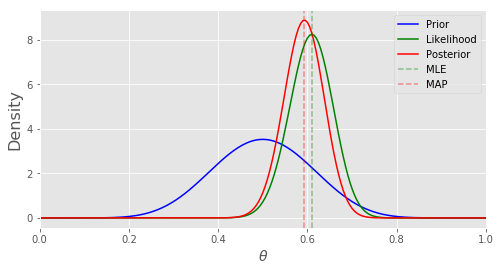

In [207]:
thetas = np.linspace(0, 1, 201)
plt.figure(figsize=(8,4))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, (n+1)*likelihood(thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.axvline(h/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

### 1.2 Numerical Integration
Let's assume the posterior distribution cannot be analytically calculated. We can still draw distribution by numerical integration. <br>
In Baye's Theorem, consider $\theta$ to be divided tightly. Then the evidence can be replaced with the equivalent sum
$$ p(X) = \sum_{\theta}^{}p(X|\theta)p(\theta)\Delta\theta $$

After calculating the evidence, the posterior distribution is computed for each finely seperated $\theta$. <br>
One advantage of this approach is that **the prior does not have to be conjugate** which means we are not restricted in our choice of an appropriate prior distribution.

In [208]:
thetas = np.linspace(0,1,201)

# prior = st.beta(a, b)
# likelihood = lambda theta: st.binom(n, theta)
post = prior.pdf(thetas) * likelihood(thetas).pmf(h)
post /= (post.sum() / len(thetas))

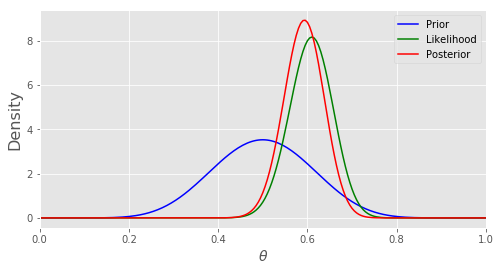

In [209]:
plt.figure(figsize=(8,4))
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior', c='red')
plt.xlim([0, 1])
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

### 1.3 Metropolis-Hasting (MH) algorithm

In [55]:
def unnorm_post(theta):
    if theta<0 or theta>1:
        return 0
    else:
        return prior.pdf(theta) * likelihood(theta).pmf(h)
    
naccept = 0
niters = 10000
stddev = 0.3
q_func = lambda theta: st.norm(theta, stddev)

# initialize
theta = 0.1
samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = q_func(theta).rvs()
    acceptance = min(1, unnorm_post(theta_p)/unnorm_post(theta))
    u = np.random.uniform()
    if u < acceptance:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
print("Efficiency = ", naccept/niters)

Efficiency =  0.1846


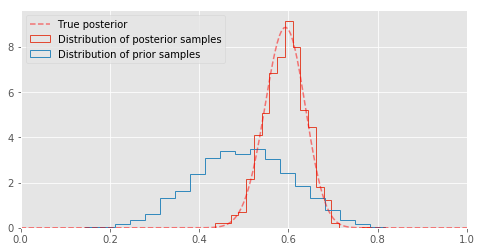

In [56]:
nmcmc = len(samples)//2 # burn out early stage
post = st.beta(h+a, n-h+b)

plt.figure(figsize=(8,4))
plt.hist(samples[nmcmc:], 45, histtype='step', density=True, linewidth=1, label='Distribution of posterior samples');
plt.hist(prior.rvs(nmcmc), 45, histtype='step', density=True, linewidth=1, label='Distribution of prior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

## 2. 2-Dimension Posterior Distribution

### 2.1 Analytic Solution

In [61]:
n1,h1 = 14,11
n2,h2 = 14,7
a,b = 2,3

# make meshgrid
def make_thetas(xmin, xmax, n):
    margin = (xmax-xmin)/(2*n)
    thetas = np.linspace(xmin+margin, xmax-margin, n)
    return thetas
thetas1 = make_thetas(0, 1, 100)
thetas2 = make_thetas(0, 1, 100)
X, Y = np.meshgrid(thetas1, thetas2)

# bayesian
prior = st.beta(a,b).pdf(X) * st.beta(a,b).pdf(Y)
likelihood = st.binom(n1,X).pmf(h1) * st.binom(n2,Y).pmf(h2)
post = st.beta(a+h1,b+n1-h1).pdf(X) * st.beta(a+h2,b+n2-h2).pdf(Y)

In [58]:
def make_plots(X, Y, prior, likelihood, posterior, projection=None):
    fig, ax = plt.subplots(1,3, subplot_kw=dict(projection=projection, aspect='equal'), figsize=(12,4))
    if projection == '3d':
        ax[0].plot_surface(X, Y, prior, alpha=0.3, cmap=plt.cm.jet)
        ax[1].plot_surface(X, Y, likelihood, alpha=0.3, cmap=plt.cm.jet)
        ax[2].plot_surface(X, Y, posterior, alpha=0.3, cmap=plt.cm.jet)
    else:
        ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
        ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
        ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.tight_layout()

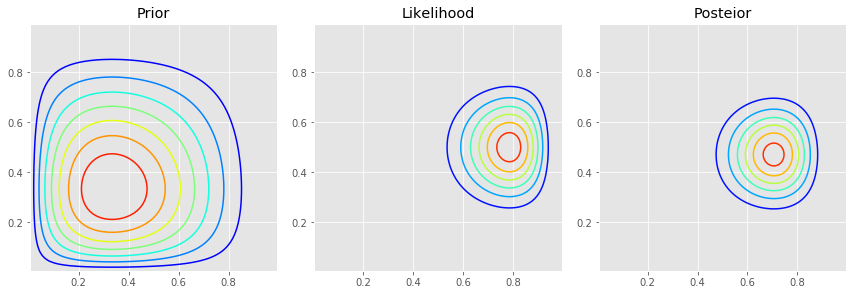

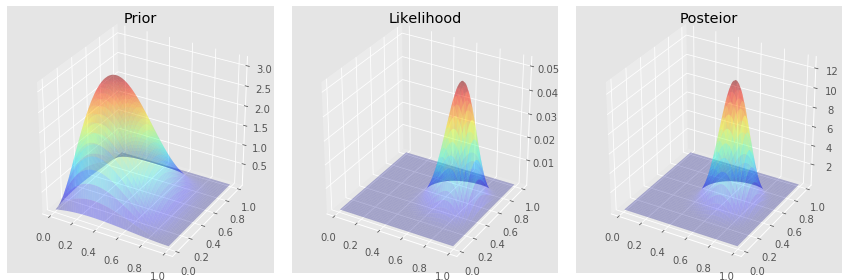

In [62]:
make_plots(X, Y, prior, likelihood, post)
make_plots(X, Y, prior, likelihood, post, projection='3d')

### 2.2 Grid Approximation

In [63]:
two_dim_beta = lambda a,b: st.beta(a,b).pdf(X) * st.beta(a,b).pdf(Y)

unnorm_prior = two_dim_beta(8,10) + two_dim_beta(3,1)
# likelihood = st.binom(n1,X).pmf(h1) * st.binom(n2,Y).pmf(h2)
unnorm_post = unnorm_prior * likelihood
post = unnorm_post / (unnorm_post.sum() / (len(thetas1) * len(thetas2)))

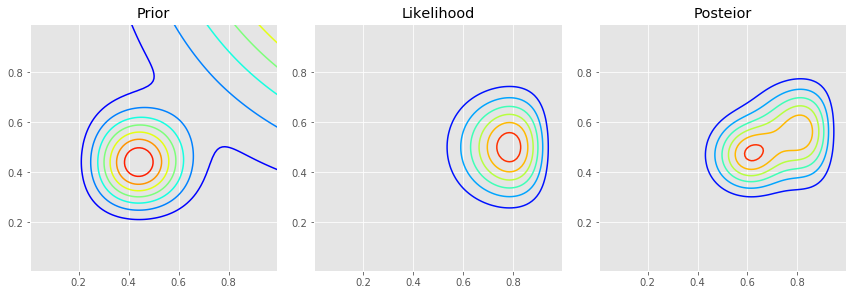

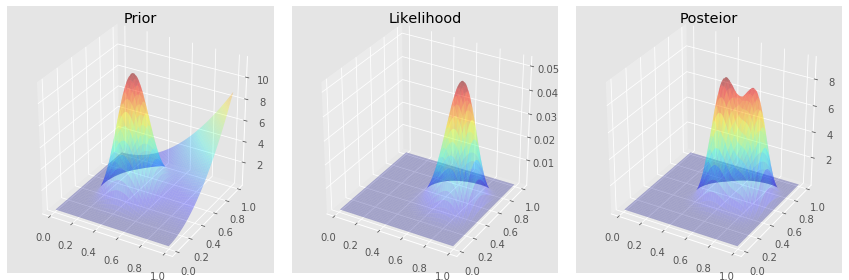

In [64]:
make_plots(X, Y, unnorm_prior, likelihood, post)
make_plots(X, Y, unnorm_prior, likelihood, post, projection='3d')

### 2.3 Matropolis-Hasting (MH) Algorithm

In [192]:
two_dim_beta = lambda a,b,theta1,theta2: st.beta(a,b).pdf(theta1) * st.beta(a,b).pdf(theta2)

# bayesian
unnorm_prior = lambda theta1,theta2: two_dim_beta(8,10,theta1,theta2) + two_dim_beta(3,1,theta1,theta2)
likelihood = lambda theta1,theta2: st.binom(n1,theta1).pmf(h1) * st.binom(n2,theta2).pmf(h2)
def unnorm_post(theta1,theta2):
    if theta1<0 or theta1>1 or theta2<0 or theta2>1:
        return 0
    else:
        return unnorm_prior(theta1,theta2) * likelihood(theta1,theta2)

In [196]:
naccept = 0
niters = 10000
stddev = np.diag([0.1,0.1])
q_func = lambda thetas: st.multivariate_normal(thetas,stddev)

#initialize
thetas = np.array([0.5,0.5])
samples = np.zeros((niters+1,2), np.float)
samples[0] = thetas

for i in range(niters):
    new_thetas = q_func(thetas).rvs()
    acceptance = min(1, unnorm_post(*(new_thetas))/unnorm_post(*(thetas)))
    u = np.random.uniform()
    if u < acceptance:
        naccept += 1
        thetas = new_thetas
    samples[i+1] = thetas
print("Efficiency = ", naccept/niters)

Efficiency =  0.191


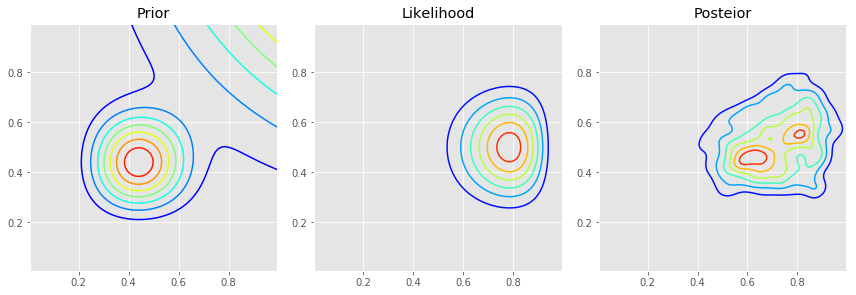

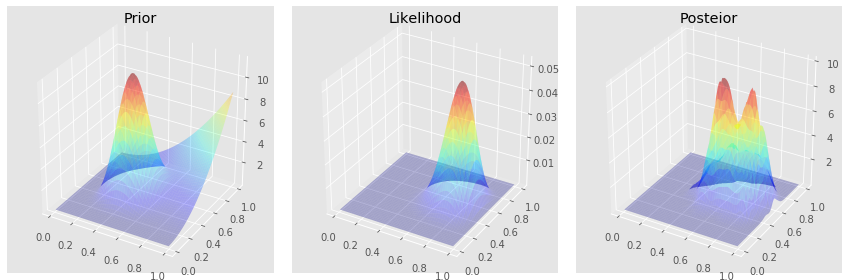

In [205]:
nmcmc = samples.shape[0]//2
kde = st.gaussian_kde(samples[nmcmc:].T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)
make_plots(X, Y, unnorm_prior(X, Y), likelihood(X, Y), posterior_metroplis)
make_plots(X, Y, unnorm_prior(X, Y), likelihood(X, Y), posterior_metroplis, projection='3d')